# 分层解冻机制
✅ fc层 (分类器) - 0.0005 lr
✅ layer4 (深层特征) - 5e-5 lr
✅ layer3 (中层特征) - 2e-5 lr
✅ layer2 (浅层特征) - 1e-5 lr

In [199]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib as mpl
import numpy as np
import os
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
# ===================== 全局配置 =====================
# 模型/数据保存路径
MODEL_PATH = "model_88.pth"
METRICS_PATH = "training_metrics.npy"
# 类别映射
from flowers102_config import CLASS_NAMES  # 或者直接复制上面提供的CLASS_NAMES列表
NUM_CLASSES = 102

# 训练参数（全局共享）
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
IMAGE_SIZE = (224, 224)

In [200]:
def check_gpu_availability():
    """验证GPU是否可用并输出详细信息"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("=" * 50)
        print("GPU加速已启用！")
        print(f"GPU设备名称: {torch.cuda.get_device_name(0)}")
        print(f"GPU设备数量: {torch.cuda.device_count()}")
        print(f"CUDA版本: {torch.version.cuda}")
        print(f"PyTorch CUDA是否可用: {torch.cuda.is_available()}")
        print("=" * 50)
    else:
        device = torch.device("cpu")
        print("=" * 50)
        print("警告：未检测到GPU，使用CPU训练/测试（速度较慢）！")
        print("=" * 50)
    return device


In [201]:
def load_data():
    """加载并预处理数据集（训练/测试共享）"""
    BASE_DIR = "flowers102_data"
    TRAIN_DIR = os.path.join(BASE_DIR, "train")
    VAL_DIR = os.path.join(BASE_DIR, "val")
    TEST_DIR = os.path.join(BASE_DIR, "test")

    # 训练集变换（含数据增强）
    train_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # 测试集变换（无数据增强）
    test_transforms = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # 加载数据集
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
    val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=test_transforms)
    test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 打印数据集信息
    print(f"训练集样本数: {len(train_dataset)}")
    print(f"验证集样本数: {len(val_dataset)}")
    print(f"测试集样本数: {len(test_dataset)}")
    print(f"类别数: {NUM_CLASSES}, 类别名称: {CLASS_NAMES}")

    return train_loader, test_loader, train_dataset, test_dataset

In [202]:
def build_model(device):
    """构建迁移学习模型（训练/测试共享）"""
    # 加载预训练的ResNet50
    model = models.resnet50(pretrained=True)
    # 冻结特征提取层
    for param in model.parameters():
        param.requires_grad = False
    # 替换全连接层
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1024),  # 从2048降到1024
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(1024, 512),                   # 1024降到512
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, NUM_CLASSES)            # 512降到102（类别数）
    )
    # 移至指定设备
    model = model.to(device)
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint)
    # 验证模型设备
    print(f"模型已加载至: {next(model.parameters()).device}")
    return model

In [203]:
def save_training_metrics(train_losses, train_accs, test_losses, test_accs):
    """保存训练指标到文件"""
    metrics = {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "test_losses": test_losses,
        "test_accs": test_accs
    }
    np.save(METRICS_PATH, metrics)
    print(f"训练指标已保存至: {METRICS_PATH}")

In [204]:
def load_training_metrics():
    """加载训练指标文件"""
    if not os.path.exists(METRICS_PATH):
        raise FileNotFoundError(f"未找到训练指标文件: {METRICS_PATH}，请先执行训练模式！")
    metrics = np.load(METRICS_PATH, allow_pickle=True).item()
    return metrics["train_losses"], metrics["train_accs"], metrics["test_losses"], metrics["test_accs"]

In [205]:
def plot_confusion_matrix(model, test_loader, device, class_names=None, save_dir="."):
    """绘制混淆矩阵图"""

    # 字体设置（复用之前的逻辑）
    available_fonts = [f.name for f in mpl.font_manager.fontManager.ttflist]
    chinese_fonts = ['WenQuanYi Micro Hei', 'DejaVu Sans',
                    'Microsoft YaHei', 'SimHei', 'SimSun',
                    'STHeiti', 'STKaiti', 'STSong']

    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            break

    if selected_font:
        plt.rcParams['font.family'] = [selected_font]
        plt.rcParams['axes.unicode_minus'] = False
    else:
        print("警告：混淆矩阵使用默认字体")

    # 设置类别名称
    if class_names is None:
        class_names = [f"Class {i}" for i in range(102)]  # 默认10个类别

    num_classes = len(class_names)

    # 初始化混淆矩阵
    conf_matrix = np.zeros((num_classes, num_classes))

    # 收集预测结果
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # 更新混淆矩阵
            for t, p in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                conf_matrix[t, p] += 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # 计算整体准确率
    correct = np.sum(np.diag(conf_matrix))
    total = np.sum(conf_matrix)
    overall_acc = correct / total if total > 0 else 0

    # 计算每个类别的准确率
    class_acc = np.zeros(num_classes)
    for i in range(num_classes):
        class_total = np.sum(conf_matrix[i, :])
        if class_total > 0:
            class_acc[i] = conf_matrix[i, i] / class_total

    # 创建带有两个子图的图形
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # 1. 混淆矩阵热力图
    ax1 = axes[0]
    # 归一化混淆矩阵（按行）
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)  # 处理除零情况

    # 热力图展示
    im = ax1.imshow(conf_matrix_norm, cmap='Blues', aspect='auto')

    ax1.set_title(f'混淆矩阵 (整体准确率: {overall_acc:.2%})', fontsize=16, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='归一化值')
    ax1.set_xlabel('预测类别', fontsize=14)
    ax1.set_ylabel('真实类别', fontsize=14)

    # 设置刻度标签
    ax1.set_xticks(np.arange(num_classes))
    ax1.set_yticks(np.arange(num_classes))
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.set_yticklabels(class_names)

    # 添加数值标注
    for i in range(num_classes):
        for j in range(num_classes):
            if conf_matrix[i, j] > 0:  # 只显示非零值
                text_color = 'white' if conf_matrix_norm[i, j] > 0.5 else 'black'
                ax1.text(j, i, f'{conf_matrix_norm[i, j]:.2f}\n({int(conf_matrix[i, j])})',
                        ha='center', va='center',
                        color=text_color, fontsize=4)

    # 2. 类别准确率柱状图
    ax2 = axes[1]
    x_pos = np.arange(num_classes)
    bars = ax2.bar(x_pos, class_acc, color='steelblue', alpha=0.7)

    ax2.set_xlabel('类别', fontsize=14)
    ax2.set_ylabel('准确率', fontsize=14)
    ax2.set_title('各类别准确率', fontsize=16, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, alpha=0.3, axis='y')

    # 添加柱状图数值标签
    for bar, acc in zip(bars, class_acc):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=10)

    # 添加平均线
    ax2.axhline(y=overall_acc, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(num_classes-0.5, overall_acc+0.02, f'平均: {overall_acc:.2%}',
             color='red', fontsize=11, ha='right')

    # 调整布局
    plt.tight_layout()

    # 保存图片
    output_path = os.path.join(save_dir, 'confusion_matrix.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight',
               facecolor='white', edgecolor='none')

    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / 1024
        print(f"✓ 混淆矩阵已保存为: {output_path}")
        print(f"✓ 文件大小: {file_size:.2f} KB")
    else:
        print("✗ 混淆矩阵保存失败")

    plt.show()

    # 打印详细的准确率信息
    print(f"\n{'='*50}")
    print(f"模型性能详细分析")
    print(f"{'='*50}")
    print(f"整体准确率: {overall_acc:.2%} ({correct}/{total})")
    print(f"{'='*50}")
    print(f"{'类别':<15} {'准确率':<12} {'正确数/总数':<15}")
    print(f"{'-'*50}")

    for i, (cls_name, acc) in enumerate(zip(class_names, class_acc)):
        class_total = np.sum(conf_matrix[i, :])
        class_correct = conf_matrix[i, i]
        print(f"{cls_name:<15} {acc:<12.2%} {int(class_correct):<4}/{int(class_total):<4}")

    print(f"{'='*50}")

    return conf_matrix, overall_acc

In [206]:
def visualize_results(train_losses, train_accs, test_losses, test_accs, train_dataset, test_dataset,
                     model=None, test_loader=None, device=None, class_names=None, save_dir="."):
    """增强的可视化分析（子图布局+字体自动检测）"""

    # 字体自动检测和设置
    available_fonts = [f.name for f in mpl.font_manager.fontManager.ttflist]
    chinese_fonts = ['WenQuanYi Micro Hei', 'DejaVu Sans',
                    'Microsoft YaHei', 'SimHei', 'SimSun',
                    'STHeiti', 'STKaiti', 'STSong',
                    'Arial Unicode MS', 'Noto Sans CJK SC']

    # 找到第一个可用的中文字体
    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            break

    if selected_font:
        # 设置字体
        plt.rcParams['font.family'] = [selected_font]
        plt.rcParams['axes.unicode_minus'] = False
        print(f"可视化字体已设置为: {selected_font}")
    else:
        print("警告：未找到中文字体，使用默认字体")

    # 计算类别分布（如果提供了class_names）
    if class_names:
        CLASS_NAMES = class_names
        NUM_CLASSES = len(class_names)
    else:
        CLASS_NAMES = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
        NUM_CLASSES = 102

    # 计算训练和测试的类别分布（如果提供了数据集路径）
    train_class_counts = []
    test_class_counts = []

    try:
        TRAIN_DIR = os.path.join("flowers102_data", "train")
        TEST_DIR = os.path.join("flowers102_data", "test")
        if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
            train_class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in CLASS_NAMES]
            test_class_counts = [len(os.listdir(os.path.join(TEST_DIR, cls))) for cls in CLASS_NAMES]
        else:
            # 如果没有文件夹，使用随机数据演示
            train_class_counts = np.random.randint(50, 100, size=NUM_CLASSES)
            test_class_counts = np.random.randint(10, 30, size=NUM_CLASSES)
    except:
        # 使用示例数据
        train_class_counts = np.random.randint(50, 100, size=NUM_CLASSES)
        test_class_counts = np.random.randint(10, 30, size=NUM_CLASSES)

    final_train_acc = train_accs[-1] if train_accs else 0
    final_test_acc = test_accs[-1] if test_accs else 0
    EPOCHS = len(train_losses) if train_losses else 0

    # ====================
    # 创建2x2的子图布局
    # ====================
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. 损失曲线
    ax1 = axes[0, 0]
    epochs_range = range(1, EPOCHS + 1)
    ax1.plot(epochs_range, train_losses, label="训练损失", marker="o", linewidth=2)
    ax1.plot(epochs_range, test_losses, label="测试损失", marker="s", linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('损失值', fontsize=12)
    ax1.set_title('训练与测试损失变化', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 添加最后epoch的数值标签
    if EPOCHS > 0:
        ax1.text(EPOCHS, train_losses[-1], f'{train_losses[-1]:.4f}',
                ha='right', va='bottom', fontsize=10)
        ax1.text(EPOCHS, test_losses[-1], f'{test_losses[-1]:.4f}',
                ha='right', va='top', fontsize=10)

    # 2. 准确率曲线
    ax2 = axes[0, 1]
    ax2.plot(epochs_range, train_accs, label="训练准确率", marker="o",
            color="green", linewidth=2)
    ax2.plot(epochs_range, test_accs, label="测试准确率", marker="s",
            color="red", linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('准确率', fontsize=12)
    ax2.set_title('训练与测试准确率变化', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.0)

    # 添加最后epoch的数值标签
    if EPOCHS > 0:
        ax2.text(EPOCHS, train_accs[-1], f'{train_accs[-1]:.4f}',
                ha='right', va='bottom', fontsize=10, color='green')
        ax2.text(EPOCHS, test_accs[-1], f'{test_accs[-1]:.4f}',
                ha='right', va='top', fontsize=10, color='red')

    # 3. 数据集类别分布
    ax3 = axes[1, 0]
    x = np.arange(len(CLASS_NAMES))
    width = 0.35

    # 创建柱状图
    bars1 = ax3.bar(x - width/2, train_class_counts, width,
                   label="训练集", color="skyblue", alpha=0.8)
    bars2 = ax3.bar(x + width/2, test_class_counts, width,
                   label="测试集", color="orange", alpha=0.8)

    ax3.set_xlabel('花卉类别', fontsize=12)
    ax3.set_ylabel('样本数量', fontsize=12)
    ax3.set_title('数据集类别分布', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(CLASS_NAMES, rotation=15, ha='right')
    ax3.legend()

    # 添加柱状图数值标签
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=4)

    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=4)

    # 4. 最终准确率对比
    ax4 = axes[1, 1]
    categories = ["训练集", "测试集"]
    acc_values = [final_train_acc, final_test_acc]
    colors = ["green", "red"]

    bars = ax4.bar(categories, acc_values, color=colors, width=0.6, alpha=0.7)
    ax4.set_xlabel('数据集', fontsize=12)
    ax4.set_ylabel('准确率', fontsize=12)
    ax4.set_title('最终准确率对比', fontsize=14, fontweight='bold')
    ax4.set_ylim(0, 1.1)
    ax4.grid(True, alpha=0.3, axis='y')

    # 添加柱状图数值标签
    for bar, value in zip(bars, acc_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontsize=11)

    # 添加整体标题
    fig.suptitle('模型训练结果综合分析', fontsize=18, fontweight='bold', y=0.98)

    # 调整布局
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 如果中文仍然显示有问题，尝试使用英文标签的备选方案
    if selected_font is None:
        print("\n注意：未找到合适的中文字体，已切换为英文标签")
        # 重新设置标签
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')

        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Accuracy', fontsize=12)
        axes[0, 1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')

        axes[1, 0].set_xlabel('Flower Class', fontsize=12)
        axes[1, 0].set_ylabel('Sample Count', fontsize=12)
        axes[1, 0].set_title('Dataset Class Distribution', fontsize=14, fontweight='bold')

        axes[1, 1].set_xlabel('Dataset', fontsize=12)
        axes[1, 1].set_ylabel('Accuracy', fontsize=12)
        axes[1, 1].set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')

        fig.suptitle('Model Training Results Analysis', fontsize=18, fontweight='bold', y=0.98)

    # 保存图片到文件
    output_path = os.path.join(save_dir, 'training_analysis.png')

    # 保存高分辨率图片
    plt.savefig(output_path, dpi=300, bbox_inches='tight',
               facecolor='white', edgecolor='none')

    # 检查文件是否保存成功
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / 1024  # 转换为KB
        print(f"✓ 可视化结果已保存为: {output_path}")
        print(f"✓ 文件大小: {file_size:.2f} KB")
        print(f"✓ 图片尺寸: {fig.get_size_inches()[0]:.1f} x {fig.get_size_inches()[1]:.1f} 英寸")
        print(f"✓ DPI: 300")
        print(f"✓ 格式: PNG")
    else:
        print("✗ 图片保存失败")

    # 显示图表
    plt.show()

    # 如果有模型和测试数据，绘制混淆矩阵
    if model is not None and test_loader is not None and device is not None:
        plot_confusion_matrix(model, test_loader, device, class_names, save_dir)

    return output_path


In [207]:
def evaluate_model(device, test_loader=None):
    """仅加载模型测试并输出结果"""
    # 加载数据（若未传入test_loader）
    if test_loader is None:
        _, test_loader, _, _ = load_data()

    # 检查模型文件
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"未找到模型文件: {MODEL_PATH}，请先执行训练模式！")

    # 构建并加载模型
    model = build_model(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    # 测试集评估
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    print("\n========== 开始测试 ==========")
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 整体指标
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 分类别指标
            for label, pred in zip(labels, predicted):
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

            pbar.set_postfix({"loss": running_loss / total, "acc": correct / total})

    # 计算最终指标
    final_loss = running_loss / len(test_loader.dataset)
    final_acc = correct / total

    # 打印结果
    print(f"\n测试完成！")
    print(f"整体测试损失: {final_loss:.4f}, 整体测试准确率: {final_acc:.4f}")
    print("\n各类别准确率:")
    for i in range(NUM_CLASSES):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{CLASS_NAMES[i]}: {acc:.4f} (正确数: {class_correct[i]}, 总数: {class_total[i]})")

    # 加载训练指标并可视化
    try:
        train_losses, train_accs, test_losses, test_accs = load_training_metrics()
        _, _, train_dataset, test_dataset = load_data()
        visualize_results(train_losses, train_accs, test_losses, test_accs, train_dataset, test_dataset)

        # 新增：测试完成后绘制混淆矩阵
        plot_confusion_matrix(model, test_loader, device)
    except FileNotFoundError as e:
        print(f"\n警告：{e}，仅展示测试结果，跳过可视化！")

In [208]:
def train_model(device):
    """重新训练模型并保存结果"""
    # 加载数据
    train_loader, test_loader, train_dataset, test_dataset = load_data()
    # 构建模型
    model = build_model(device)
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # 训练指标记录
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_test_acc = 0.0

    # 开始训练
    print("\n========== 开始训练 ==========")
    for epoch in range(EPOCHS):
        # 训练一个epoch
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 统计
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({"loss": running_loss / total, "acc": correct / total})
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # 验证
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            pbar = tqdm(test_loader, desc="Validation")
            for images, labels in pbar:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar.set_postfix({"loss": running_loss / total, "acc": correct / total})
        test_loss = running_loss / len(test_loader.dataset)
        test_acc = correct / total

        # 学习率衰减
        scheduler.step()

        # 记录指标
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # 保存最优模型
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"保存最优模型，测试准确率: {best_test_acc:.4f}")

        # 打印epoch结果
        print(f"Epoch {epoch + 1} | 训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
        print(f"          | 测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}\n")

    # 保存训练指标
    save_training_metrics(train_losses, train_accs, test_losses, test_accs)
    print(f"训练完成！最优测试准确率: {best_test_acc:.4f}")

    # 可视化结果
    visualize_results(train_losses, train_accs, test_losses, test_accs, train_dataset, test_dataset)

    # 新增：训练完成后绘制混淆矩阵
    plot_confusion_matrix(model, test_loader, device)

    # 最终评估
    evaluate_model(device, test_loader)

In [209]:
def create_layered_optimizer(model, lr_fc=0.001, lr_layer4=0.0001, lr_layer3=0.00001, lr_layer2=0.000005):
    """
    为不同层设置不同的学习率
    越深的层（预训练特征）学习率越小
    新加的fc层学习率较大
    """
    # 按层分组参数
    params = []

    # fc层：最高学习率（从0开始学的）
    params.append({
        'params': model.fc.parameters(),
        'lr': lr_fc,
        'name': 'fc_layer'
    })

    # layer4：中等学习率（微调高级特征）
    params.append({
        'params': model.layer4.parameters(),
        'lr': lr_layer4,
        'name': 'layer4'
    })

    # layer3：较低学习率（稍微调整中级特征）
    params.append({
        'params': model.layer3.parameters(),
        'lr': lr_layer3,
        'name': 'layer3'
    })
    params.append({
        'params': model.layer2.parameters(),
        'lr': lr_layer2,  # ← 最低的学习率
        'name': 'layer2'
    })

    optimizer = optim.Adam(params, weight_decay=0.001)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # ← 添加标签平滑

    print("\n🎯 分层学习率设置:")
    for param_group in optimizer.param_groups:
        print(f"  {param_group['name']}: lr = {param_group['lr']}")

    return optimizer

In [210]:
def unfreeze_layers(model, num_layers_to_unfreeze=5):
    """
    逐步解冻ResNet的层
    num_layers_to_unfreeze: 解冻多少层
    1 = 只解冻最后的fc层（默认）
    2 = 解冻layer4
    3 = 解冻layer3和layer4
    4 = 解冻layer2、layer3、layer4
    """
    print("=" * 50)
    print("解冻模型层:")
    print("=" * 50)

    # 先冻结所有层
    for param in model.parameters():
        param.requires_grad = False

    # 按需解冻
    if num_layers_to_unfreeze >= 1:
        # 解冻最后的fc层（一定要解冻）
        for param in model.fc.parameters():
            param.requires_grad = True
        print("✅ 已解冻: fc层 (分类器)")

    if num_layers_to_unfreeze >= 2:
        # 解冻layer4（最后一层卷积）
        for param in model.layer4.parameters():
            param.requires_grad = True
        print("✅ 已解冻: layer4 (高级特征)")

    if num_layers_to_unfreeze >= 3:
        # 解冻layer3
        for param in model.layer3.parameters():
            param.requires_grad = True
        print("✅ 已解冻: layer3 (中级特征)")

    if num_layers_to_unfreeze >= 4:
        # 解冻layer2
        for param in model.layer2.parameters():
            param.requires_grad = True
        print("✅ 已解冻: layer2 (初级特征)")

    if num_layers_to_unfreeze >= 5:  # ← 新增这部分
        for param in model.layer1.parameters():
            param.requires_grad = True
        print("⚠️  已解冻: layer1 (基础特征，需极低学习率)")

    # 打印训练参数统计
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"\n📊 参数统计:")
    print(f"  总参数: {total_params:,}")
    print(f"  可训练参数: {trainable_params:,} ({trainable_params/total_params:.1%})")
    print(f"  冻结参数: {frozen_params:,} ({frozen_params/total_params:.1%})")

    return model

# 使用：先解冻3层（layer4, layer3, fc）
    model = unfreeze_layers(model, num_layers_to_unfreeze=4)

In [211]:
def continue_training(device, epochs=10, checkpoint_path=MODEL_PATH):
    """
    继续训练已有模型
    """
    print("=" * 60)
    print("🔄 继续训练模式")
    print("=" * 60)

    # 1. 加载数据
    train_loader, test_loader, train_dataset, test_dataset = load_data()

    # 2. 构建模型并加载权重
    model = build_model(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    print(f"✅ 已加载预训练权重: {checkpoint_path}")

    # 3. 解冻层（从第4层开始）
    model = unfreeze_layers(model, num_layers_to_unfreeze=4)

    # 4. 创建分层优化器
    optimizer = create_layered_optimizer(
        model,
        lr_fc=0.001,
        lr_layer4=0.0001,
        lr_layer3=0.00001,
        lr_layer2=0.00001,
    )

    # 5. 使用加权损失函数
    criterion = WeightedCrossEntropyLoss()

    # 6. 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # 监控准确率（越大越好）
        patience=2,  # 2个epoch没提升就降学习率
        factor=0.5,  # 降为原来的一半
        verbose=True
    )

    # 7. 记录指标
    best_test_acc = 0
    class_acc_history = []  # 记录每个epoch每个类的准确率

    for epoch in range(epochs):
        print(f"\n📊 Epoch {epoch+1}/{epochs}")

        # 训练
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()

            # 梯度裁剪（防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # 统计
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / train_total
        avg_train_acc = train_correct / train_total

        # 测试
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        # 记录每个类的准确率
        class_correct = [0] * 102
        class_total = [0] * 102

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)

                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                # 统计每个类
                for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                    class_total[label] += 1
                    if label == pred:
                        class_correct[label] += 1

        avg_test_loss = test_loss / test_total
        avg_test_acc = test_correct / test_total

        # 记录每个类的准确率
        class_acc = []
        for i in range(102):
            if class_total[i] > 0:
                class_acc.append(class_correct[i] / class_total[i])
            else:
                class_acc.append(0)
        class_acc_history.append(class_acc)

        # 打印结果
        print(f"  训练损失: {avg_train_loss:.4f}, 训练准确率: {avg_train_acc:.4f}")
        print(f"  测试损失: {avg_test_loss:.4f}, 测试准确率: {avg_test_acc:.4f}")

        # 特别关注0%的类
        zero_percent_classes = [6, 25, 67, 48, 90, 50, 27, 19]
        print("  🔍 0%类的进展:")
        for cls in zero_percent_classes:
            if class_total[cls] > 0:
                acc = class_correct[cls] / class_total[cls]
                print(f"    {CLASS_NAMES[cls]}: {acc:.1%} ({class_correct[cls]}/{class_total[cls]})")

        # 更新学习率
        scheduler.step(avg_test_acc)

        # 保存最好的模型
        if avg_test_acc > best_test_acc:
            best_test_acc = avg_test_acc
            torch.save(model.state_dict(), "continued_best_model.pth")
            print(f"  💾 保存新最佳模型，准确率: {best_test_acc:.4f}")

    # 保存完整的训练历史
    history = {
        'class_acc_history': class_acc_history,
        'best_test_acc': best_test_acc,
        'epochs': epochs
    }
    torch.save(history, "training_history.pth")

    return model, class_acc_history

In [212]:
class WeightedCrossEntropyLoss(nn.Module):
    """给准确率低的类更高权重"""

    def __init__(self, class_weights=None):
        super().__init__()
        if class_weights is None:
            # 根据你的测试结果设置权重
            # 0%的类权重=5.0，100%的类权重=0.1
            self.class_weights = torch.ones(102)

            # 特别差的类
            very_bad_classes = [2, 11, 13, 14, 25, 26, 30, 31, 34, 35, 38, 39, 50, 71, 73, 82, 83, 84, 85, 88, 90, 96, 97, 98, 99]   # 0%的类
            for cls in very_bad_classes:
                self.class_weights[cls] = 4.0

            # 特别好的类（少更新）
            very_good_classes = [6, 7, 19, 55, 62, 64, 67]  # 100%的类
            for cls in very_good_classes:
                self.class_weights[cls] = 0.1
        else:
            self.class_weights = class_weights

    def forward(self, logits, labels):
        # 计算每个样本的基础损失
        loss = F.cross_entropy(logits, labels, reduction='none')

        # 获取每个样本对应的类别权重
        weights = self.class_weights.to(logits.device)[labels]

        # 加权损失
        weighted_loss = weights * loss

        return weighted_loss.mean()

# 使用加权损失
criterion = WeightedCrossEntropyLoss()

In [213]:
class ClassBalancedFocalLoss(nn.Module):
    """根据历史准确率动态调整权重的Focal Loss"""

    def __init__(self, num_classes=102, init_acc=0.5, update_freq=100):
        super().__init__()
        self.num_classes = num_classes
        # 初始化每个类别的准确率估计
        self.register_buffer('class_accuracies', torch.full((num_classes,), init_acc))
        self.update_freq = update_freq
        self.step_count = 0

    def update_accuracies(self, preds, labels):
        """更新每个类别的准确率估计"""
        batch_size = labels.size(0)
        with torch.no_grad():
            for cls_idx in range(self.num_classes):
                mask = (labels == cls_idx)
                if mask.sum() > 0:
                    # 计算这个batch中该类的准确率
                    correct = (preds[mask] == labels[mask]).sum().item()
                    acc = correct / mask.sum().item()
                    # 指数移动平均更新
                    self.class_accuracies[cls_idx] = (
                        0.9 * self.class_accuracies[cls_idx] + 0.1 * acc
                    )
        self.step_count += 1

    def forward(self, logits, labels):
        """
        logits: [batch_size, num_classes]
        labels: [batch_size]
        """
        # 计算每个样本的基础交叉熵损失
        ce_loss = F.cross_entropy(logits, labels, reduction='none')  # [batch_size]

        # 计算预测概率（当前模型对该样本的置信度）
        probs = torch.softmax(logits, dim=1)
        pt = probs.gather(1, labels.unsqueeze(1)).squeeze()  # [batch_size]

        # 获取每个样本所属类别的历史准确率
        class_acc = self.class_accuracies[labels]  # [batch_size]

        # 动态计算权重：准确率越低，权重越高
        # 使用sigmoid函数，使权重在[1, 10]范围内
        alpha = 1 + 9 * (1 - torch.sigmoid(class_acc * 10 - 5))

        # Focal Loss：对难以分类的样本（pt小）赋予更高权重
        # 同时乘以类别权重：难学的类权重更高
        focal_weight = (1 - pt) ** 2

        # 组合损失
        loss = alpha * focal_weight * ce_loss

        # 记录预测结果用于更新准确率（仅在训练时）
        if self.training:
            _, preds = torch.max(logits, 1)
            self.update_accuracies(preds, labels)

        return loss.mean()

In [214]:
def continue_training(device, epochs=10, checkpoint_path=MODEL_PATH):
    """
    继续训练已有模型
    """
    print("=" * 60)
    print("🔄 继续训练模式")
    print("=" * 60)

    # 1. 加载数据
    train_loader, test_loader, train_dataset, test_dataset = load_data()

    # 2. 构建模型并加载权重
    model = build_model(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    print(f"✅ 已加载预训练权重: {checkpoint_path}")

    # 3. 解冻层（从第3层开始）
    model = unfreeze_layers(model, num_layers_to_unfreeze=4)

    # 4. 创建分层优化器
    optimizer = create_layered_optimizer(
    model,
    lr_fc=0.0005,      # ← 降低fc层学习率
    lr_layer4=0.00005, # ← 降低layer4学习率
    lr_layer3=0.00002, # ← 降低layer3学习率
    lr_layer2=0.00001, # ← 新增！解冻layer2
)


    # 5. 使用加权损失函数
    criterion = WeightedCrossEntropyLoss()

    # 6. 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # 监控准确率（越大越好）
        patience=2,  # 2个epoch没提升就降学习率
        factor=0.5,  # 降为原来的一半
    )

    # 7. 记录指标
    best_test_acc = 0
    class_acc_history = []  # 记录每个epoch每个类的准确率

    for epoch in range(epochs):
        print(f"\n📊 Epoch {epoch+1}/{epochs}")

        # 训练
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()

            # 梯度裁剪（防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # 统计
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / train_total
        avg_train_acc = train_correct / train_total

        # 测试
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        # 记录每个类的准确率
        class_correct = [0] * 102
        class_total = [0] * 102

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)

                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                # 统计每个类
                for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                    class_total[label] += 1
                    if label == pred:
                        class_correct[label] += 1

        avg_test_loss = test_loss / test_total
        avg_test_acc = test_correct / test_total

        # 记录每个类的准确率
        class_acc = []
        for i in range(102):
            if class_total[i] > 0:
                class_acc.append(class_correct[i] / class_total[i])
            else:
                class_acc.append(0)
        class_acc_history.append(class_acc)

        # 打印结果
        print(f"  训练损失: {avg_train_loss:.4f}, 训练准确率: {avg_train_acc:.4f}")
        print(f"  测试损失: {avg_test_loss:.4f}, 测试准确率: {avg_test_acc:.4f}")

        # 特别关注0%的类
        zero_percent_classes = [11, 13, 34, 38, 71, 84, 88, 98]
        print("  🔍 0%类的进展:")
        for cls in zero_percent_classes:
            if class_total[cls] > 0:
                acc = class_correct[cls] / class_total[cls]
                print(f"    {CLASS_NAMES[cls]}: {acc:.1%} ({class_correct[cls]}/{class_total[cls]})")

        # 更新学习率
        scheduler.step(avg_test_acc)

        # 保存最好的模型
        if avg_test_acc > best_test_acc:
            best_test_acc = avg_test_acc
            torch.save(model.state_dict(), "continued_best_model.pth")
            print(f"  💾 保存新最佳模型，准确率: {best_test_acc:.4f}")

    # 保存完整的训练历史
    history = {
        'class_acc_history': class_acc_history,
        'best_test_acc': best_test_acc,
        'epochs': epochs
    }
    torch.save(history, "training_history.pth")

    return model, class_acc_history

In [215]:
def train_with_adaptive_loss(device):
    """使用自适应损失函数训练"""
    # 加载数据
    train_loader, test_loader, train_dataset, test_dataset = load_data()

    # 构建模型
    model = build_model(device)

    # 使用AdaptiveFocalLoss
    criterion = ClassBalancedFocalLoss(num_classes=102, init_acc=0.5)
    criterion = criterion.to(device)

    # 仅训练最后的分类层（FC）
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # 记录每个类别的准确率变化
    class_acc_history = {i: [] for i in range(102)}

    for epoch in range(EPOCHS):
        model.train()

        # 每个epoch开始时，打印当前各类别的权重
        print(f"\nEpoch {epoch+1} - 类别权重统计:")
        weights = criterion.class_accuracies.cpu().numpy()
        worst_10 = np.argsort(weights)[:10]  # 权重最高的10个类（准确率最低）
        best_10 = np.argsort(weights)[-10:]  # 权重最低的10个类（准确率最高）

        print("最难学的10个类（权重高）:")
        for idx in worst_10:
            print(f"  {CLASS_NAMES[idx]}: 权重={weights[idx]:.3f}")

        print("最容易的10个类（权重低）:")
        for idx in best_10:
            print(f"  {CLASS_NAMES[idx]}: 权重={weights[idx]:.3f}")

        # 训练循环
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 验证并记录每个类别的准确率
        model.eval()
        class_correct = [0] * 102
        class_total = [0] * 102

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                    class_total[label] += 1
                    if label == pred:
                        class_correct[label] += 1

        # 记录每个类别的准确率
        for cls_idx in range(102):
            if class_total[cls_idx] > 0:
                acc = class_correct[cls_idx] / class_total[cls_idx]
                class_acc_history[cls_idx].append(acc)

        # 打印改进最明显的类
        if epoch > 0:
            print(f"\nEpoch {epoch+1} - 改进最明显的5个类:")
            improvements = []
            for cls_idx in range(102):
                if len(class_acc_history[cls_idx]) >= 2:
                    curr_acc = class_acc_history[cls_idx][-1]
                    prev_acc = class_acc_history[cls_idx][-2]
                    improvements.append((cls_idx, curr_acc - prev_acc))

            improvements.sort(key=lambda x: x[1], reverse=True)
            for cls_idx, imp in improvements[:5]:
                print(f"  {CLASS_NAMES[cls_idx]}: +{imp:.3f} "
                      f"(从{class_acc_history[cls_idx][-2]:.3f}到{class_acc_history[cls_idx][-1]:.3f})")

GPU加速已启用！
GPU设备名称: NVIDIA GeForce RTX 4060 Laptop GPU
GPU设备数量: 1
CUDA版本: 12.8
PyTorch CUDA是否可用: True
请选择:
1. 从头开始训练
2. 继续训练（解冻层，重点训练差生类）
3. 仅测试（使用已训练的模型）
训练集样本数: 1020
验证集样本数: 1020
测试集样本数: 6149
类别数: 102, 类别名称: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', '

Testing: 100%|██████████| 193/193 [00:28<00:00,  6.73it/s, loss=0.488, acc=0.883]



测试完成！
整体测试损失: 0.4876, 整体测试准确率: 0.8827

各类别准确率:
pink primrose: 0.9500 (正确数: 19, 总数: 20)
hard-leaved pocket orchid: 0.9750 (正确数: 39, 总数: 40)
canterbury bells: 0.8060 (正确数: 54, 总数: 67)
sweet pea: 0.8947 (正确数: 34, 总数: 38)
english marigold: 1.0000 (正确数: 28, 总数: 28)
tiger lily: 0.9552 (正确数: 64, 总数: 67)
moon orchid: 0.4138 (正确数: 12, 总数: 29)
bird of paradise: 0.8214 (正确数: 23, 总数: 28)
monkshood: 0.9655 (正确数: 28, 总数: 29)
globe thistle: 0.9524 (正确数: 20, 总数: 21)
snapdragon: 0.9846 (正确数: 64, 总数: 65)
colt's foot: 0.8387 (正确数: 52, 总数: 62)
king protea: 0.9310 (正确数: 27, 总数: 29)
spear thistle: 0.9444 (正确数: 34, 总数: 36)
yellow iris: 0.7500 (正确数: 15, 总数: 20)
globe-flower: 0.9000 (正确数: 18, 总数: 20)
purple coneflower: 0.8462 (正确数: 33, 总数: 39)
peruvian lily: 0.8592 (正确数: 61, 总数: 71)
balloon flower: 1.0000 (正确数: 22, 总数: 22)
giant white arum lily: 0.6667 (正确数: 14, 总数: 21)
fire lily: 0.8571 (正确数: 18, 总数: 21)
pincushion flower: 1.0000 (正确数: 20, 总数: 20)
fritillary: 1.0000 (正确数: 46, 总数: 46)
red ginger: 1.0000 (正确数:

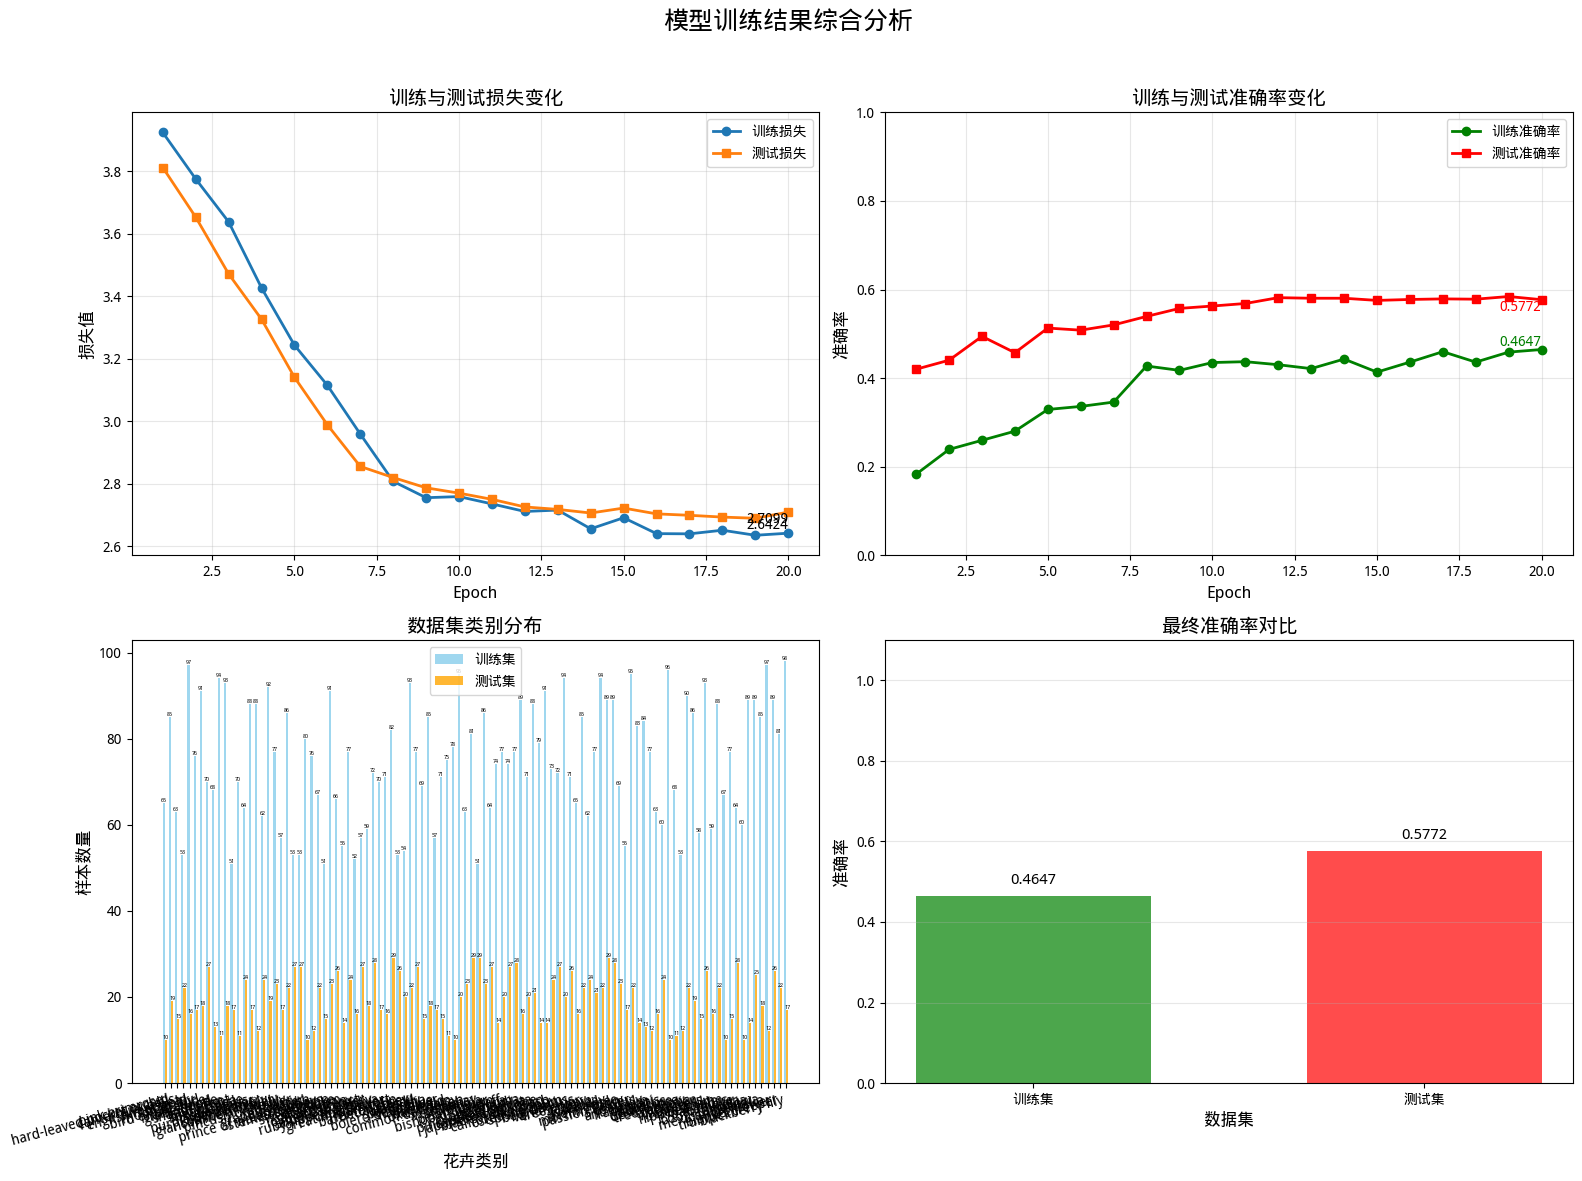

✓ 混淆矩阵已保存为: ./confusion_matrix.png
✓ 文件大小: 1299.91 KB


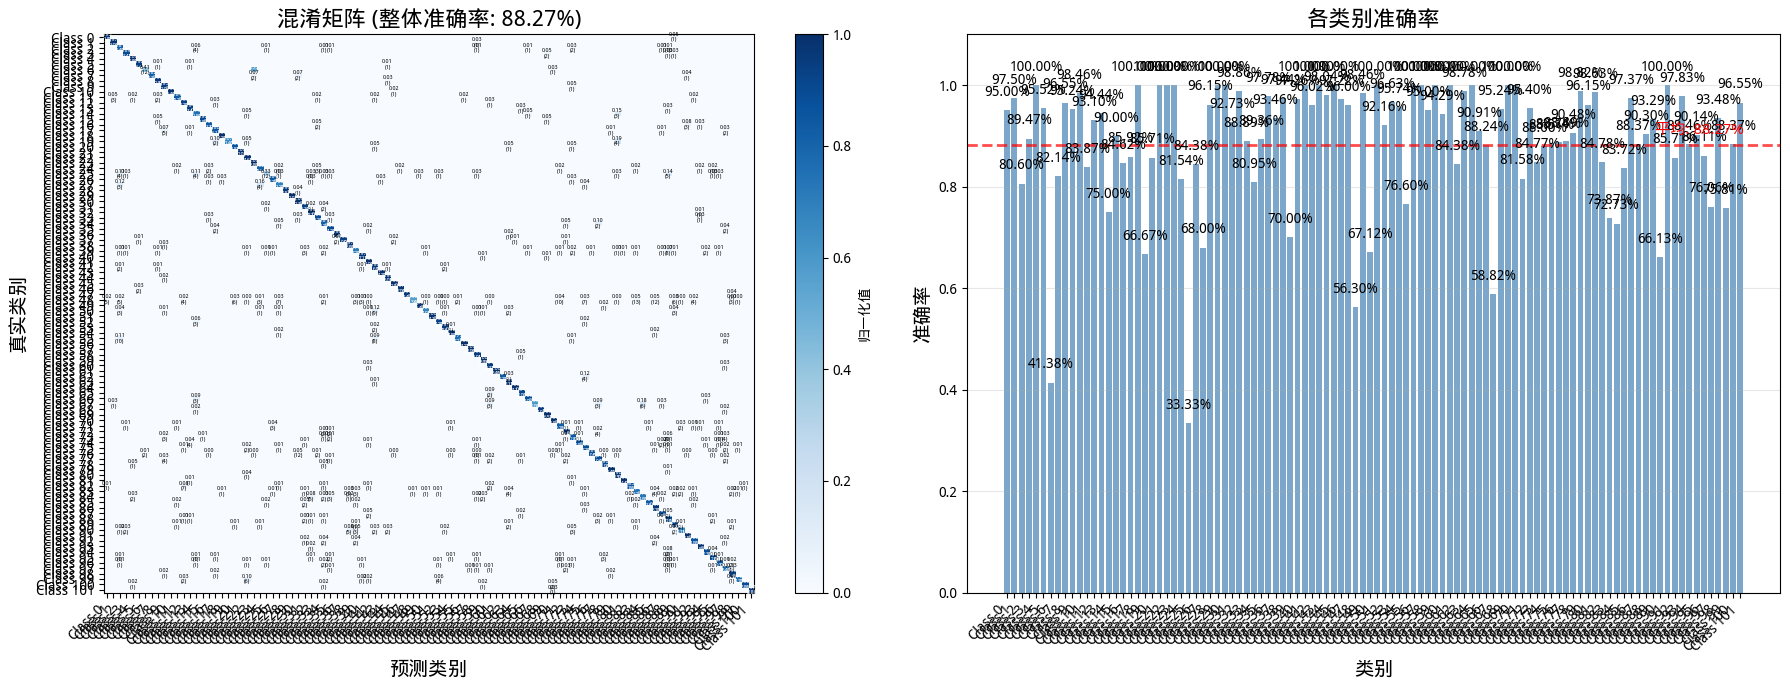


模型性能详细分析
整体准确率: 88.27% (5428.0/6149.0)
类别              准确率          正确数/总数         
--------------------------------------------------
Class 0         95.00%       19  /20  
Class 1         97.50%       39  /40  
Class 2         80.60%       54  /67  
Class 3         89.47%       34  /38  
Class 4         100.00%      28  /28  
Class 5         95.52%       64  /67  
Class 6         41.38%       12  /29  
Class 7         82.14%       23  /28  
Class 8         96.55%       28  /29  
Class 9         95.24%       20  /21  
Class 10        98.46%       64  /65  
Class 11        83.87%       52  /62  
Class 12        93.10%       27  /29  
Class 13        94.44%       34  /36  
Class 14        75.00%       15  /20  
Class 15        90.00%       18  /20  
Class 16        84.62%       33  /39  
Class 17        85.92%       61  /71  
Class 18        100.00%      22  /22  
Class 19        66.67%       14  /21  
Class 20        85.71%       18  /21  
Class 21        100.00%      20  /20  
Class 

In [216]:
if __name__ == '__main__':
    # 设备初始化
    device = check_gpu_availability()

    # # 模式选择
    # print("\n========== 花卉分类模型 ==========")
    # print("请选择运行模式：")
    # print("1. 重新训练模型（会覆盖原有模型和训练指标）")
    # print("2. 仅测试（使用已训练的模型）")
    # while True:
    #     try:
    #         choice = int(input("输入选择（1/2）："))
    #         if choice in [1, 2]:
    #             break
    #         else:
    #             print("请输入1或2！")
    #     except ValueError:
    #         print("请输入有效的数字（1/2）！")
    #
    # # 执行对应模式
    # if choice == 1:
    #     train_model(device)
    # elif choice == 2:
    #     evaluate_model(device)
    print("请选择:")
    print("1. 从头开始训练")
    print("2. 继续训练（解冻层，重点训练差生类）")
    print("3. 仅测试（使用已训练的模型）")

    choice = input("输入选择 (1/2/3): ")

    if choice == '1':
        train_model(device)
    elif choice == '2':
    # 继续训练10个epoch
        model, class_acc_history = continue_training(device, epochs=10)
    elif choice == '3':
       evaluate_model(device)
# 分析哪个类进步最大
print("\n🎯 进步最明显的类:")
if class_acc_history and len(class_acc_history) > 0:
        final_acc = class_acc_history[-1]  # 最后一个epoch
        initial_acc = class_acc_history[0]  # 第一个epoch

        improvements = []
        for i in range(102):
            if initial_acc[i] < 0.5:  # 只关注原本表现不好的
                improvements.append((i, final_acc[i] - initial_acc[i]))

        improvements.sort(key=lambda x: x[1], reverse=True)
        for i, imp in improvements[:10]:
            print(f"  {CLASS_NAMES[i]}: 从{initial_acc[i]:.1%}到{final_acc[i]:.1%} (+{imp:.1%})")